In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import glob
%matplotlib inline

In [3]:
DATA_FOLDER = './data'
OUTPUT_FOLDER = './output'

In [4]:
RESOLUTION = '20.0'

In [5]:
NETCFD_FILE_ETA = DATA_FOLDER + '/eta_eulerian_resolution_' + RESOLUTION + 'km.nc'
NETCFD_FILE_U = DATA_FOLDER + '/u_eulerian_resolution_' + RESOLUTION + 'km.nc'
NETCFD_FILE_V = DATA_FOLDER + '/v_eulerian_resolution_' + RESOLUTION + 'km.nc'

In [6]:
ds_u = xr.open_mfdataset(NETCFD_FILE_U)
ds_u

<xarray.Dataset>
Dimensions:                        (time: 36656, x: 101, y: 100)
Coordinates:
  * time                           (time) float64 0.0 70.71 ... 2.592e+06
  * x                              (x) float64 -1e+04 1e+04 ... 1.99e+06
  * y                              (y) float64 -1e+06 -9.8e+05 ... 9.8e+05
Data variables:
    __xarray_dataarray_variable__  (y, x, time) float64 dask.array<shape=(100, 101, 36656), chunksize=(100, 101, 36656)>

In [7]:
ds_u = ds_u.rename({'x':'x_sw', 'y':'y_sw','__xarray_dataarray_variable__':'u'})
ds_u

<xarray.Dataset>
Dimensions:  (time: 36656, x_sw: 101, y_sw: 100)
Coordinates:
  * time     (time) float64 0.0 70.71 141.4 ... 2.592e+06 2.592e+06 2.592e+06
  * x_sw     (x_sw) float64 -1e+04 1e+04 3e+04 ... 1.95e+06 1.97e+06 1.99e+06
  * y_sw     (y_sw) float64 -1e+06 -9.8e+05 -9.6e+05 ... 9.4e+05 9.6e+05 9.8e+05
Data variables:
    u        (y_sw, x_sw, time) float64 dask.array<shape=(100, 101, 36656), chunksize=(100, 101, 36656)>

In [8]:
da_u = ds_u.isel(x_sw=slice(0,100)).u
da_u

<xarray.DataArray 'u' (y_sw: 100, x_sw: 100, time: 36656)>
dask.array<shape=(100, 100, 36656), dtype=float64, chunksize=(100, 100, 36656)>
Coordinates:
  * time     (time) float64 0.0 70.71 141.4 ... 2.592e+06 2.592e+06 2.592e+06
  * x_sw     (x_sw) float64 -1e+04 1e+04 3e+04 ... 1.93e+06 1.95e+06 1.97e+06
  * y_sw     (y_sw) float64 -1e+06 -9.8e+05 -9.6e+05 ... 9.4e+05 9.6e+05 9.8e+05

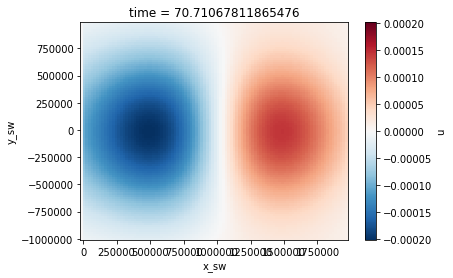

In [9]:
da_u[:,:,1].plot()

In [10]:
da_u.mean().values

array(-1.87999056e-06)

In [11]:
da_u.std().values

array(0.02800084)

In [12]:
ds_v = xr.open_mfdataset(NETCFD_FILE_V)
ds_v = ds_v.rename({'x':'x_sw', 'y':'y_sw','__xarray_dataarray_variable__':'v'})
da_v = ds_v.isel(y_sw=slice(0,100)).v
da_v

<xarray.DataArray 'v' (y_sw: 100, x_sw: 100, time: 36656)>
dask.array<shape=(100, 100, 36656), dtype=float64, chunksize=(100, 100, 36656)>
Coordinates:
  * time     (time) float64 0.0 70.71 141.4 ... 2.592e+06 2.592e+06 2.592e+06
  * y_sw     (y_sw) float64 -1.01e+06 -9.9e+05 -9.7e+05 ... 9.5e+05 9.7e+05
  * x_sw     (x_sw) float64 0.0 2e+04 4e+04 6e+04 ... 1.94e+06 1.96e+06 1.98e+06

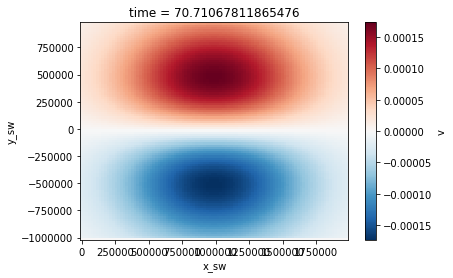

In [13]:
da_v[:,:,1].plot()

In [14]:
da_v.mean().values

array(1.21505271e-08)

In [15]:
da_v.std().values

array(0.01868383)

In [16]:
ds_eta = xr.open_mfdataset(NETCFD_FILE_ETA)
ds_eta = ds_eta.rename({'x':'x_sw', 'y':'y_sw','__xarray_dataarray_variable__':'eta'})
da_eta = ds_eta.eta
da_eta

<xarray.DataArray 'eta' (y_sw: 100, x_sw: 100, time: 36656)>
dask.array<shape=(100, 100, 36656), dtype=float64, chunksize=(100, 100, 36656)>
Coordinates:
  * time     (time) float64 0.0 70.71 141.4 ... 2.592e+06 2.592e+06 2.592e+06
  * y_sw     (y_sw) float64 -1e+06 -9.8e+05 -9.6e+05 ... 9.4e+05 9.6e+05 9.8e+05
  * x_sw     (x_sw) float64 0.0 2e+04 4e+04 6e+04 ... 1.94e+06 1.96e+06 1.98e+06

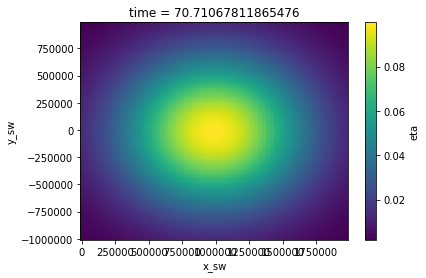

In [17]:
da_eta[:,:,1].plot()

In [18]:
def create_sequence_ds(dataset, x_step=1, x_size=5, y_step=1, y_size=5):
    time_size = dataset.time.size
    one_sample_size = ((x_size * x_step) + (y_size * y_step)) - (x_size - 1)
    sample_size = time_size - one_sample_size
    x_list, y_list = __process_sequence_ds(dataset, x_step, x_size, y_step, y_size, sample_size)
    x_data = xr.concat(x_list, dim='sample')
    x_data = x_data.expand_dims(dim='channel', axis=-1)
    y_data = xr.concat(y_list, dim='sample')
    y_data = y_data.expand_dims(dim='channel', axis=-1)
    
    print('Sample size: ', x_data.sample.size)
    
    return x_data, y_data

def __process_sequence_ds(dataset, x_step, x_size, y_step, y_size, sample_size):
    x_list, y_list = [], []
    x_i, y_i = 0, 0
    for i in range(sample_size):
        x_f = x_i + (x_step * y_size)
        x_data = dataset.isel(time=slice(x_i, x_f, x_step))
        x_data = x_data.expand_dims(dim='sample', axis=0)
        x_i = x_i + 1
        y_i = x_f
        y_f = y_i + (y_step * y_size)
        y_data = dataset.isel(time=slice(y_i, y_f, y_step))
        y_data = y_data.expand_dims(dim='sample', axis=0)
        if y_data.time.size < y_size:
            break
        x_data = x_data.drop(labels='time')
        x_list.append(x_data)
        y_data = y_data.drop(labels='time')
        y_list.append(y_data)

    return x_list, y_list

In [19]:
X_SIZE = 5
Y_SIZE = 5
X_STEP = 5
Y_STEP = 5

In [ ]:
%%time

input_data_u, target_data_u = create_sequence_ds(da_u, x_step = X_STEP, y_step = Y_STEP, y_size = Y_SIZE)
ds_u = xr.Dataset({'x': input_data_u, 'y': target_data_u})
ds_u = ds_u.transpose('sample', 'time', 'y_sw', 'x_sw', 'channel')
ds_u

In [ ]:
input_data_v, target_data_v = create_sequence_ds(da_v, x_step = X_STEP, y_step = Y_STEP, y_size = Y_SIZE)
ds_v = xr.Dataset({'x': input_data_v, 'y': target_data_v})
ds_v = ds_v.transpose('sample', 'time', 'y_sw', 'x_sw', 'channel')
ds_v

In [20]:
input_data_eta, target_data_eta = create_sequence_ds(da_eta, x_step = X_STEP, y_step = Y_STEP, y_size = Y_SIZE)
ds_eta = xr.Dataset({'x': input_data_eta, 'y': target_data_eta})
ds_eta = ds_eta.transpose('sample', 'time', 'y_sw', 'x_sw', 'channel')
ds_eta

Sample size:  36610


<xarray.Dataset>
Dimensions:  (channel: 1, sample: 36610, time: 5, x_sw: 100, y_sw: 100)
Coordinates:
  * y_sw     (y_sw) float64 -1e+06 -9.8e+05 -9.6e+05 ... 9.4e+05 9.6e+05 9.8e+05
  * x_sw     (x_sw) float64 0.0 2e+04 4e+04 6e+04 ... 1.94e+06 1.96e+06 1.98e+06
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, y_sw, x_sw, channel) float64 dask.array<shape=(36610, 5, 100, 100, 1), chunksize=(1, 5, 100, 100, 1)>
    y        (sample, time, y_sw, x_sw, channel) float64 dask.array<shape=(36610, 5, 100, 100, 1), chunksize=(1, 5, 100, 100, 1)>

In [ ]:
ds = xr.concat([ds_u, ds_v, ds_eta], 'channel')
ds

In [ ]:
del(input_data_eta)
del(target_data_eta)
del(input_data_u)
del(target_data_u)
del(input_data_v)
del(target_data_v)

In [ ]:
del(ds_u)
del(ds_v)

In [21]:
NEW_FILE_ETA = OUTPUT_FOLDER + '/dataset-shallow-water-eta-' + RESOLUTION + 'km-yseq' + str(Y_SIZE) +'-ystep' + str(Y_STEP) + '.nc'
NEW_FILE_U = OUTPUT_FOLDER + '/dataset-shallow-water-u-' + RESOLUTION + 'km-yseq' + str(Y_SIZE) +'-ystep' + str(Y_STEP) + '.nc'
NEW_FILE_V = OUTPUT_FOLDER + '/dataset-shallow-water-v-' + RESOLUTION + 'km-yseq' + str(Y_SIZE) +'-ystep' + str(Y_STEP) + '.nc'

In [22]:
%%time
ds_eta.to_netcdf(NEW_FILE_ETA)

CPU times: user 1min 58s, sys: 47.9 s, total: 2min 46s
Wall time: 3min 56s


### Testing Pre-Processing

In [ ]:
ds_eta.x[100, 0, :, :, 0].values == da_eta[:, :, 100].values

In [ ]:
ds_eta.x[0, 1, :, :, 0].values == da_eta[:, :, 15].values

In [ ]:
ds_eta.x[15, 4, :, :, 0].values == ds_eta.y[0, 0, :, :, 0].values

In [ ]:
da_eta.time[5]